# Requirements
* bigWigAverageOverBed (hgdownload.soe.ucsc.edu/admin/exe/. Make sure it is executable and in the $PATH.)
* numpy
* matplotlib
* tensorflow
* keras
* sklearn

# Data Source
* Download http://hgdownload.soe.ucsc.edu/gbdb/hg19/bbi/wgEncodeOpenChromDnaseNhekSig.bigWig

In [1]:
# generate 100bp bin bed file
!awk 'BEGIN{x=0; id=1}{while(x+bin <= $2) {print $1"\t"x"\t"x+bin-1"\t"id; x+=bin; id+=1}x=0}' \
bin=100 hg19_chr.lengths > hg19_100b_bins.bed

In [3]:
# generate average score of Dnase bigwig over 100b bed
!bigWigAverageOverBed ./wgEncodeOpenChromDnaseNhekSig.bigWig ./hg19_100b_bins.bed ./Dnase.tab

processing chromosomes.......................


In [4]:
# normalize the Dnase data
import numpy as np
from math import pi
from numpy import arctan
from scipy.stats import iqr

epidata = np.loadtxt('Dnase.tab', usecols=(3))
Q3 = np.quantile(epidata, 0.75)
epidata = epidata/(Q3+1.5*iqr(epidata))
epidata = 2*arctan(epidata)/pi

inputstart = 0
inputstop = 0
outputstart = 0
outputstop = 0
m = np.zeros((61903, 500))
with open('hg19_chr.lengths') as chr:
    for line in chr:
        chrom, chrlength = line.split()
        chrlength = int(chrlength)
        inputstart = inputstop
        inputstop = inputstop + chrlength//100
        outputstart = outputstop
        outputstop = outputstop + chrlength//50000
        for j in range(outputstart, outputstop):
            m[j, :] = epidata[inputstart:inputstart+500]
            inputstart += 500
    np.save('Dnase_norm', m)

In [5]:
# normalize the DSB data
dsbdata = np.loadtxt('NHEK_BREAK_50kb.bedgraph', usecols=(3))
Q3 = np.quantile(dsbdata, 0.75)
dsbdata = dsbdata/(Q3+1.5*iqr(dsbdata))
dsbdata = 2*arctan(dsbdata)/pi

np.save('DSB_norm', dsbdata)

In [12]:
# training
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Conv1D
from keras.layers import MaxPool1D, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import initializers
import sklearn.metrics
import os
from sklearn.model_selection import train_test_split
os.mkdir('model')

model = Sequential()
model.add(Conv1D(32, 3, activation = 'relu', input_shape = (500,1), kernel_initializer=initializers.Ones()))
model.add(BatchNormalization())
model.add(MaxPool1D(2))
model.add(Conv1D(32, 3, activation = 'relu', kernel_initializer=initializers.Ones()))
model.add(BatchNormalization())
model.add(MaxPool1D(2))
model.add(Conv1D(32, 3, activation = 'relu', kernel_initializer=initializers.Ones()))
model.add(BatchNormalization())
model.add(MaxPool1D(2))
model.add(Flatten())
model.add(Dense(32, activation = 'relu'))
model.add(Dense(1))
model.summary()

model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

x =np.load('Dnase_norm.npy')
x = x[:,:,np.newaxis].astype('float32')
y = np.load('DSB_norm.npy').astype('float32')

x_train, x_test, y_train, y_test = train_test_split(x, 
                                                    y, 
                                                    test_size=0.25,
                                                   random_state=0)

checkpoint = ModelCheckpoint('model/' + 'aaa', monitor='val_loss', verbose=1, save_best_only=True)
early_stopping_monitor = EarlyStopping(monitor='val_loss', patience = 5)
history = model.fit(x_train, y_train, epochs=50, batch_size=128, verbose=1, validation_split=0.2, callbacks=[checkpoint, early_stopping_monitor])
y_pred = model.predict(x_test, verbose=1)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 498, 32)           128       
_________________________________________________________________
batch_normalization_4 (Batch (None, 498, 32)           128       
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 249, 32)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 247, 32)           3104      
_________________________________________________________________
batch_normalization_5 (Batch (None, 247, 32)           128       
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 123, 32)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 121, 32)          

37141/37141 [==============================] - 20s 550us/step - loss: 0.0033 - mae: 0.0363 - val_loss: 0.0055 - val_mae: 0.0542

Epoch 00031: val_loss did not improve from 0.00356
Epoch 32/50
37141/37141 [==============================] - 20s 550us/step - loss: 0.0032 - mae: 0.0361 - val_loss: 0.0040 - val_mae: 0.0431

Epoch 00032: val_loss did not improve from 0.00356
Epoch 33/50
37141/37141 [==============================] - 20s 548us/step - loss: 0.0032 - mae: 0.0358 - val_loss: 0.0040 - val_mae: 0.0425

Epoch 00033: val_loss did not improve from 0.00356
Epoch 34/50
37141/37141 [==============================] - 20s 552us/step - loss: 0.0032 - mae: 0.0358 - val_loss: 0.0048 - val_mae: 0.0458

Epoch 00034: val_loss did not improve from 0.00356
15476/15476 [==============================] - 2s 120us/step


In [13]:
# calculate Pearson's correlation
y_pred = model.predict(x_test, verbose=1)

import math
def calcMean(x,y):
    sum_x = sum(x)
    sum_y = sum(y)
    n = len(x)
    x_mean = float(sum_x+0.0)/n
    y_mean = float(sum_y+0.0)/n
    return x_mean,y_mean

def calcPearson(x,y):
    x_mean,y_mean = calcMean(x,y)
    n = len(x)
    sumTop = 0.0
    sumBottom = 0.0
    x_pow = 0.0
    y_pow = 0.0
    for i in range(n):
        sumTop += (x[i]-x_mean)*(y[i]-y_mean)
    for i in range(n):
        x_pow += math.pow(x[i]-x_mean,2)
    for i in range(n):
        y_pow += math.pow(y[i]-y_mean,2)
    sumBottom = math.sqrt(x_pow*y_pow)
    p = sumTop/sumBottom
    return p

Pearson = calcPearson(y_test, y_pred)
print(Pearson)

15476/15476 [==============================] - 2s 114us/step
[0.84968805]


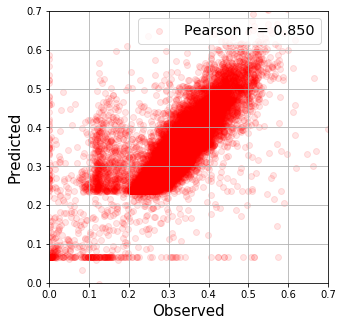

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

font = {'size': 15}
plt.figure(figsize=(5,5))
plt.xlim(0,0.7)
plt.ylim(0,0.7)
plt.xlabel('Observed', font)
plt.ylabel('Predicted', font)
plt.grid(True)
plt.scatter(y_test, y_pred, c='r', alpha=0.1, label='Pearson r = %0.3f' % Pearson)
plt.legend(loc=1, fontsize='x-large')
plt.show()